# Análise da Base de Dados SRAG 2023 do Open Data SUS

## Introdução

Este projeto tem como objetivo realizar uma análise da base de dados de Síndrome Respiratória Aguda Grave (SRAG) de 2023, disponibilizada pelo Open Data SUS. A Síndrome Respiratória Aguda Grave é uma condição que exige vigilância constante devido à sua potencial gravidade e impacto significativo na saúde pública. Com a utilização de técnicas de análise de dados, pretendemos extrair insights que possam contribuir para uma melhor compreensão dos padrões de incidência e disseminação da SRAG ao longo do ano.

Temos alguns objetivos:

Tratamento de Dados:
* Identificar e corrigir possíveis problemas nos dados.
* Documentar todas as etapas de pré-processamento para garantir transparência.

Análise Descritiva Inicial:
* Explorar os principais atributos da base de dados.
* Identificar e descreva tendências temporais ao longo do ano de 2023.
* Analisar a distribuição geográfica dos casos de SRAG.
* Analisar a presença de fatores de risco e comorbidades nos casos de SRAG.

Conclusão e Recomendações:
* Resumir os principais insights e descobertas da análise.
* Sugerir possíveis intervenções ou políticas de saúde pública com base nos resultados obtidos.


A base de dados e seu dicionário podem ser encontrados em: https://opendatasus.saude.gov.br/dataset/srag-2021-a-2024

## 1 - Leitura dos dados

In [2]:
# importações
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import numpy as np
from category_encoders.ordinal import OrdinalEncoder
from scipy.stats import chi2_contingency

c:\Users\joao.antunes\AppData\Local\miniconda3\envs\ambienteds\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# leitura dos dados
df1 = pd.read_csv('INFLUD23-22-04-2024.csv', sep=';') # definido o separador para ler corretamente
df1.head()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,VG_ENC,VG_REINF,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG
0,08/02/2023,6,07/02/2023,6,CE,11 CRES SOBRAL,1521.0,SOBRAL,231290,HOSPITAL REGIONAL NORTE,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/02/2023,6,09/02/2023,6,SP,GVE XVII CAMPINAS,1342.0,CAMPINAS,350950,HOSPITAL E MATERNIDADE CELSO PIERRO,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07/02/2023,6,05/02/2023,6,SP,GVE XIX MARILIA,1344.0,MARILIA,352900,SANTA CASA DE MARILIA,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08/02/2023,6,23/01/2023,4,RS,014 CRS,1602.0,CAMPINA DAS MISSOES,430370,POSTO DE SAUDE SEDE E PACS CAMPINA DAS MISSOES,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07/02/2023,6,05/02/2023,6,PE,001,1497.0,RECIFE,261160,SOCIEDADE HOSPITALAR MARIA VITORIA,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# fazendo uma cópia dos dados
df = df1.copy()

In [5]:
# listando as colunas com tipos de dados misturados
colunas_warning = df.columns[[15,18,20,23,53,57,59,61,62,63,66,67,72,74,79,85,91,93,105,107,109,120,121,122,128,130,143,145,146,148,149,171,175,176,178,179,183,186,188]]
df.shape

(278539, 190)

## 2 - Limpeza dos dados

PS. Ao ler o dicionário de dados e durante a análise exploratória, identifiquei colunas no dataframe que não estão documentadas. Vamos dropar essas colunas para não atrapalhar a análise.

Além disso, vamos dropar também colunas de dados pessoais e outras colunas que julgo que não agregarão à uma análise mais geral.

In [6]:
# lsita de campos no dicionário de dados
campos_dicionario = [
    "NU_NOTIFIC","FATOR_RISC","TOMO_RES","SG_UF","DT_UT_DOSE","FLUBLI_OUT",
    "DT_NOTIFIC","PUERPERA","TOMO_OUT","ID_RG_RESI","MAE_VAC","POS_PCROUT",
    "SEM_NOT","CARDIOPATI","DT_TOMO","CO_RG_RESI","DT_VAC_MAE","PCR_ SARS2",
    "DT_SIN_PRI","HEMATOLOGI","AMOSTRA","ID_MN_RESI","M_AMAMENTA","PCR_VSR",
    "SEM_PRI","SIND_DOWN","DT_COLETA","CO_MUN_RES","DT_DOSEUNI","PCR_PARA1",
    "SG_UF_NOT","HEPATICA","TP_AMOSTRA","NM_BAIRRO","DT_1_DOSE","PCR_PARA2",
    "ID_MUNICIP","ASMA","OUT_AMOST","NM_LOGRADO","DT_2_DOSE","PCR_PARA3",
    "CO_MUN_NOT","DIABETES","REQUI_GAL","NU_NUMERO","ANTIVIRAL","PCR_PARA4",
    "ID_REGIONA","NEUROLOGIC","TP_TES_AN","NM_COMPLEM","TP_ANTIVIR","PCR_ADENO",
    "CO_REGIONA","PNEUMOPATI","DT_RES_AN","NU_DDD_TEL","OUT_ANTIV","PCR_METAP",
    "ID_UNIDADE","IMUNODEPRE","RES_AN","NU_TELEFON","DT_ANTIVIR","PCR_BOCA",
    "CO_UNI_NOT","RENAL","DT_RES_LAB","CS_ZONA","TRAT_COV","PCR_RINO",
    "TEM_CPF","OBESIDADE","CO_LAB_AN","ID_PAIS","TIPO_TRAT","PCR_OUTRO",
    "NU_CPF","OBES_IMC","POS_AN_FLU","CO_PAIS","OUT_TRAT","DS_PCR_OUT",
    "ESTRANG","OUT_MORBI","TP_FLU_AN","NOSOCOMIAL","DT_TRT_COV","LAB_PCR",
    "NU_CNS","MORB_DESC","POS_AN_OUT","AVE_SUINO","HOSPITAL","CO_LAB_PCR",
    "NM_PACIENT","VACINA_COV","AN_SARS2","OUT_ANIM","DT_INTERNA","TP_AM_SOR",
    "CS_SEXO","DOSE_1_COV","AN_VSR","FEBRE","SG_UF_INTE","SOR_OUT",
    "DT_NASC","DOSE_2_COV","AN_PARA1","TOSSE","CO_RG_INTE","DT_CO_SOR",
    "NU_IDADE_N","DOSE_REF","AN_PARA2","GARGANTA","ID_RG_INTE","TP_SOR",
    "TP_IDADE","DOSE_2REF","AN_PARA3","DISPNEIA","CO_MU_INTE","OUT_SOR",
    "CS_GESTANT","FAB_COV1","AN_ADENO","DESC_RESP","ID_MN_INTE","SOR_OUT",
    "CS_RACA","FAB_COV2","AN_OUTRO","SATURACAO","CO_UN_INTE","RES_IGG",
    "CS_ETINIA","FAB_COVRF","DS_AN_OUT","DIARREIA","ID_UN_INTE","RES_IGM",
    "POV_CT","FAB_COVRF2","PCR_RESUL","VOMITO","UTI","RES_IGA",
    "TP_POV_CT","LOTE_1_COV","DT_PCR","DOR_ABD","DT_ENTUTI","DT_RES",
    "CS_ESCOL_N","LOTE_2_COV","POS_PCRFLU","FADIGA","DT_SAIDUTI","CLASSI_FIN",
    "PAC_COCBO","LOTE_REF","TP_FLU_PCR","PERD_OLFT","SUPORT_VEN","CLASSI_OUT",
    "PAC_DSCBO","LOTE_REF2","PCR_FLUASU","PERD_PALA","RAIOX_RES","CRITERIO",
    "NM_MAE_PAC","FNT_IN_COV","FLUASU_OUT","OUTRO_SIN","RAIOX_OUT","EVOLUCAO",
    "NU_CEP","VACINA","PCR_FLUBLI","OUTRO_DES","DT_RAIOX","DT_EVOLUCA"
]

In [7]:
# lista de campos de dados pessoais e outros
colunas_sair = [
    "CO_RG_RESI",	"ID_RG_INTE",	"CLASSI_OUT",
    "ESTRANG",	"CO_RG_INTE",	"OUT_ANIM",
    "CS_ESCOL_N",	"ID_MN_INTE",	"TOMO_OUT",
    "PAC_DSCBO",	"CO_MU_INTE",	"DT_TOMO",
    "ID_RG_RESI",	"RAIOX_OUT",	"TP_TES_AN",
    "ID_MN_RESI",	"DT_RAIOX",	"DT_RES_AN",
    "CO_MUN_RES",	"DT_COLETA",	"TP_FLU_AN",
    "PAC_COCBO",	"OUT_AMOST",	"POS_AN_OUT",
    "ID_PAIS",	"DT_PCR",	"DS_AN_OUT",
    "CO_PAIS",	"POS_PCRFLU",	"TP_AM_SOR",
    "TP_AMOSTRA",	"TP_FLU_PCR",	"SOR_OUT",
    "SEM_NOT",	"PCR_FLUASU",	"DT_CO_SOR",
    "ID_REGIONA",	"FLUASU_OUT",	"TP_SOR",
    "CO_REGIONA",	"PCR_FLUBLI",	"OUT_SOR",
    "ID_MUNICIP",	"FLUBLI_OUT",	"DT_RES",
    "CO_MUN_NOT",	"POS_PCROUT",	"RES_IGG",
    "ID_UNIDADE",	"PCR_VSR",	"RES_IGM",
    "CO_UNI_NOT",	"PCR_PARA1",	"RES_IGA",
    "OUTRO_DES",	"PCR_PARA2",	"LOTE_1_COV",
    "OBES_IMC",	"PCR_PARA3",	"LOTE_2_COV",
    "MORB_DESC",	"PCR_PARA4",	"LOTE_REF",
    "DT_VAC_MAE",	"PCR_ADENO",	"FNT_IN_COV",
    "DT_DOSEUNI",	"PCR_METAP",	"FAB_COVRF2",
    "DT_1_DOSE",	"PCR_BOCA",	"LOTE_REF2",
    "DT_2_DOSE",	"PCR_RINO",	"TIPO_TRAT",
    "OUT_ANTIV",	"PCR_OUTRO",	"OUT_TRAT",
    "DT_ANTIVIR",	"DS_PCR_OUT",	"DT_TRT_COV",
]

In [8]:
# dropando as colunas que não estão no dicionário
srag = df.drop(columns=df.columns.difference(campos_dicionario))
srag.shape

(278539, 158)

In [9]:
# dropando colunas de dados pessoais e outros
srag = srag.drop(columns=colunas_sair)
srag.shape

(278539, 77)

Vamos começar tratando as colunas que receberam warning de mixed types na leitura, porém nesse ponto algumas já foram dropadas.
São elas: 
* ['COD_IDADE', 'CS_ESCOL_N', 'CO_PAIS', 'CO_RG_RESI', 'OBES_IMC', 'DT_VAC_MAE', 'DT_DOSEUNI', 'DT_1_DOSE', 'DT_2_DOSE', 'OUT_ANTIV', 'DT_ANTIVIR', 'CO_RG_INTE', 'CO_MU_INTE', 'OUT_AMOST', 'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'CLASSI_OUT', 'PAC_COCBO', 'PAC_DSCBO', 'OUT_ANIM', 'TOMO_OUT', 'TP_TES_AN', 'DS_AN_OUT', 'SOR_OUT', 'DT_CO_SOR', 'OUT_SOR', 'DT_RES', 'OUT_TRAT', 'VG_OMSOUT', 'VG_LIN', 'VG_METOUT', 'VG_DTRES', 'FAB_ADIC', 'DOSE_ADIC', 'LOTE_ADIC'] (apontados pelo erro ao tentar filtrar o df pela lista anteior)
  
Vamos retirar esses dados da lista e filtrar o novo dataframe

In [10]:
lista_remove = ['COD_IDADE', 'CS_ESCOL_N', 'CO_PAIS', 'CO_RG_RESI', 
                'OBES_IMC', 'DT_VAC_MAE', 'DT_DOSEUNI', 'DT_1_DOSE', 
                'DT_2_DOSE', 'OUT_ANTIV', 'DT_ANTIVIR', 'CO_RG_INTE', 
                'CO_MU_INTE', 'OUT_AMOST', 'FLUASU_OUT', 'FLUBLI_OUT', 
                'DS_PCR_OUT', 'CLASSI_OUT', 'PAC_COCBO', 'PAC_DSCBO', 
                'OUT_ANIM', 'TOMO_OUT', 'TP_TES_AN', 'DS_AN_OUT', 
                'SOR_OUT', 'DT_CO_SOR', 'OUT_SOR', 'DT_RES', 
                'OUT_TRAT', 'VG_OMSOUT', 'VG_LIN', 'VG_METOUT', 
                'VG_DTRES', 'FAB_ADIC', 'DOSE_ADIC', 'LOTE_ADIC']

# nova lista sem as colunas dropadas
colunas_warning = [item for item in colunas_warning if item not in lista_remove]
colunas_warning

['DT_UT_DOSE', 'RAIOX_RES', 'EVOLUCAO']

In [11]:
# convertendo colunas de data para datetime
srag['DT_ENTUTI'] = pd.to_datetime(srag['DT_ENTUTI'], format='%d/%m/%Y', errors = 'coerce') # foi necessário usar o errors = 'coerce' devido a valores fora dos limites (outofbounds error)
srag['DT_EVOLUCA'] = pd.to_datetime(srag['DT_EVOLUCA'], format='%d/%m/%Y', errors = 'coerce') # esses valores serão registrados como NaT
srag['DT_INTERNA'] = pd.to_datetime(srag['DT_INTERNA'], format='%d/%m/%Y', errors = 'coerce')
srag['DT_NASC'] = pd.to_datetime(srag['DT_NASC'], format='%d/%m/%Y', errors = 'coerce')
srag['DT_NOTIFIC'] = pd.to_datetime(srag['DT_NOTIFIC'], format='%d/%m/%Y', errors = 'coerce')
srag['DT_SAIDUTI'] = pd.to_datetime(srag['DT_SAIDUTI'], format='%d/%m/%Y', errors = 'coerce')
srag['DT_SIN_PRI'] = pd.to_datetime(srag['DT_SIN_PRI'], format='%d/%m/%Y', errors = 'coerce')
srag['DT_UT_DOSE'] = pd.to_datetime(srag['DT_UT_DOSE'], format='%d/%m/%Y', errors = 'coerce')

In [12]:
# corrigindo a coluna RAIOX_RES
print(srag['RAIOX_RES'].unique()) # O problema de tipo da coluna é o valor 'HIPERINSUFLACAO PULMONAR'

srag['RAIOX_RES'] = (srag['RAIOX_RES']
                     .str.replace('HIPERINSUFLACAO PULMONAR', '5')
                     .fillna(9) # 9 = ignorado
                     .astype('int')
                     )

print(srag['RAIOX_RES'].unique())

[9.0 nan 2.0 5.0 6.0 1.0 3.0 4.0 '2' '5' '6' '9' '1' '3' '4'
 'HIPERINSUFLACAO PULMONAR']
[9 2 5 6 1 3 4]


In [13]:
print(srag['EVOLUCAO'].unique())

srag['EVOLUCAO'] = (srag['EVOLUCAO']
                     .str.replace('15/', '9')
                     .str.replace('10/', '9')
                     .fillna('9') # 9 = ignorado
                     .apply(lambda x: pd.to_numeric(x, errors = 'ignore')) # astype não funcionou
                     )

print(srag['EVOLUCAO'].unique())

[1.0 3.0 nan 2.0 9.0 '1' '9' '2' '3' '15/' '10/']
[9 1 2 3]


A partir desse ponto, vou tratando a medida que for utilizando a coluna e agregando abaixo.

In [14]:
# Como a proposta é analisar apenas o ano de 2023, vamos manter as linhas apenas em que o ano da data de noficação seja 2023.
srag = srag[srag['DT_NOTIFIC'].dt.year == 2023]

In [15]:
# Tratando os NaN nas colunas de sintomas
lista_sintomas = ['DESC_RESP', 'DIARREIA', 'DISPNEIA', 'DOR_ABD', 'FADIGA', 'FEBRE','GARGANTA', 'OUTRO_SIN', 'PERD_OLFT', 'PERD_PALA', 'SATURACAO', 'VOMITO']

# Tratando os NaN e substituindo por valor em string para melhor visualização
for sintoma in lista_sintomas:
    srag[sintoma] = (srag[sintoma].fillna(9)
                                  .replace({1: 'Sim', 2:'Não', 9:'Ignorado'}))

# dropando um valor errado da coluna 'PERD_PALA' (identificado na análise)
i = srag[srag['PERD_PALA'] == 6].index
srag = srag.drop(i)


In [16]:
# Tratando os NaN nas colunas de fatores de risco
fatores_risco = ['FATOR_RISC','ASMA', 'CARDIOPATI', 'DIABETES', 'HEMATOLOGI', 'HEPATICA', 'IMUNODEPRE','NEUROLOGIC', 'OBESIDADE', 'OUT_MORBI', 'PNEUMOPATI', 'PUERPERA', 'RENAL', 'SIND_DOWN']

# Tratando os NaN e substituindo por valor em string para melhor visualização
for fator in fatores_risco:
    srag[fator] = (srag[fator].fillna(9)
                                  .replace({1: 'Sim', 2:'Não', 9:'Ignorado'}))

In [17]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['CLASSI_FIN'] = (srag['CLASSI_FIN'].fillna(4) # não especificado
                                  .replace({1: 'Influenza', 2:'Outro vírus respiratório', 3:'Outro agente etiológico', 4:'Não especificado', 5:'COVID'}))

In [18]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['CS_ZONA'] = (srag['CS_ZONA'].fillna(9) # Ignorado
                                  .replace({1: 'Urbana', 2:'Rural', 3:'Periurbana', 9:'Ignorado'}))

In [19]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['EVOLUCAO'] = (srag['EVOLUCAO'].fillna(9) # Ignorado
                                  .replace({1: 'Cura', 2:'Óbito', 3:'Óbito por outras causas', 9:'Ignorado'}))

In [20]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['CS_RACA'] = (srag['CS_RACA'].fillna(9) # Ignorado
                                  .replace({1: 'Branca', 2:'Preta', 3:'Amarela',4:'Parda',5:'Indígena', 9:'Ignorado'}))

In [21]:
# criando a coluna de idade
srag['IDADE'] = np.where(srag['TP_IDADE'] == 1, srag['NU_IDADE_N'] / 365, # se estiver em dia, divide por 365
                 np.where(srag['TP_IDADE'] == 2, srag['NU_IDADE_N'] / 12, # se estiver em meses, divide por 12
                 srag['NU_IDADE_N'])) # caso esteja em anos, deixa como está

# dropando idades com valores incoerentes
id_neg = srag[(srag['IDADE'] < 0) | ((srag['IDADE'] > 110))].index
srag = srag.drop(id_neg)

In [22]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
for vacina in ['VACINA', 'VACINA_COV']:
    srag[vacina] = (srag[vacina].fillna(9)
                                  .replace({1: 'Sim', 2:'Não', 9:'Ignorado'}))

In [23]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['TRAT_COV'] = (srag['TRAT_COV'].fillna(9)
                            .replace({1: 'Sim', 2:'Não', 9:'Ignorado'}))

In [24]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['HOSPITAL'] = (srag['HOSPITAL'].fillna(9)
                                    .replace({1: 'Sim', 2:'Não', 9:'Ignorado'}))

# dropando idades com valores incoerentes
id_neg = srag[(srag['HOSPITAL'] == 0)].index
srag = srag.drop(id_neg)

In [25]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['UTI'] = (srag['UTI'].fillna(9)
                          .replace({1: 'Sim', 2:'Não', 9:'Ignorado'}))

In [26]:
# Tratando os NaN e substituindo por valor em string para melhor visualização
srag['SUPORT_VEN'] = (srag['SUPORT_VEN'].fillna(9)
                                        .replace({1: 'Sim', 2:'Sim', 3:'Não', 9:'Ignorado'})) 
# a base faz diferenciação entre suporte invasivo e não invasivo, porém iremos ignorar essa segmentação e usar apenas sim ou não

## 3 - Análise Exploratória

In [27]:
srag.info()
print(srag.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 275628 entries, 0 to 278538
Data columns (total 78 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DT_NOTIFIC  275628 non-null  datetime64[ns]
 1   DT_SIN_PRI  275628 non-null  datetime64[ns]
 2   SEM_PRI     275628 non-null  int64         
 3   SG_UF_NOT   275628 non-null  object        
 4   CS_SEXO     275628 non-null  object        
 5   DT_NASC     275539 non-null  datetime64[ns]
 6   NU_IDADE_N  275628 non-null  int64         
 7   TP_IDADE    275628 non-null  int64         
 8   CS_GESTANT  275628 non-null  int64         
 9   CS_RACA     275628 non-null  object        
 10  SG_UF       275560 non-null  object        
 11  CS_ZONA     275628 non-null  object        
 12  NOSOCOMIAL  242929 non-null  float64       
 13  AVE_SUINO   232467 non-null  float64       
 14  FEBRE       275628 non-null  object        
 15  TOSSE       250749 non-null  float64       
 16  GARGANT

Ainda temos 77 colunas que podem ser úteis para nossa análise. Algumas delas tem pouquíssimos valores não nulos, por se tratarem de colunas condicionadas a outras colunas. Por hora, vamos mantê-las.

In [28]:
srag = srag.drop_duplicates()
print(srag.shape)

(275369, 78)


Havia algumas linhas duplicadas que foram dropadas.

In [29]:
srag.CS_SEXO.value_counts()

CS_SEXO
M    142229
F    133120
I        20
Name: count, dtype: int64

Em 2023 houveram pouco mais de 9k casos notificados a mais de homens do que de mulheres. Cerca de 3%

In [30]:
srag['IDADE'].describe()

count    275369.000000
mean         31.132129
std          34.062813
min           0.000000
25%           1.000000
50%           8.000000
75%          67.000000
max         110.000000
Name: IDADE, dtype: float64

Distribuição de idades assimétrica à direita (média > mediana). Ou seja, SRAG acomete mais pessoas com idades avançadas. Um desvio padrão alto indica uma alta variabilidade nas idades.

In [31]:
# teste V de Cramer para correlação de variáveis categóricas

colunas = ['IDADE', 'FATOR_RISC', 'CLASSI_FIN', 'EVOLUCAO']

# encode das variáveis selecionadas
encoder = OrdinalEncoder(cols = colunas, return_df = True)
srag_encod = pd.DataFrame()
srag_encod[colunas] = encoder.fit_transform(srag[colunas])

def V_de_cramer(var1,var2):
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0] # teste chi-quadrado
  obs = np.sum(crosstab) # numero de observações
  mini = min(crosstab.shape)-1 # pega o valor mínimo entre as colunas e as linhas da tabela cruzada
  return np.sqrt(stat/(obs*mini))

lins= []

for var1 in srag_encod:
  col = []
  for var2 in srag_encod :
    cramers =V_de_cramer(srag_encod[var1], srag_encod[var2]) # teste V de Cramer
    col.append(round(cramers,2)) 
  lins.append(col)
  
cramers_results = np.array(lins)
df_corr = pd.DataFrame(cramers_results, columns = srag_encod.columns, index =srag_encod.columns)
df_corr

,IDADE,FATOR_RISC,CLASSI_FIN,EVOLUCAO
IDADE,1.00,0.53,0.26,0.04
FATOR_RISC,0.53,1.00,0.27,0.04
CLASSI_FIN,0.26,0.27,1.00,0.02
EVOLUCAO,0.04,0.04,0.02,1.00


O teste V de Cramer é uma medida estatística que avalia a associação entre duas variáveis categóricas, com base na estatística do qui-quadrado ajustada ao tamanho da amostra e ao número de categorias das variáveis.

A correlação mais forte observada é entre a idade e fatores de risco, o que é esperado, uma vez que são mais frequentes com o envelhecimento. Outras variáveis apresentam correlação fracas a muito fracas.

### 3.1 - Análise Temporal

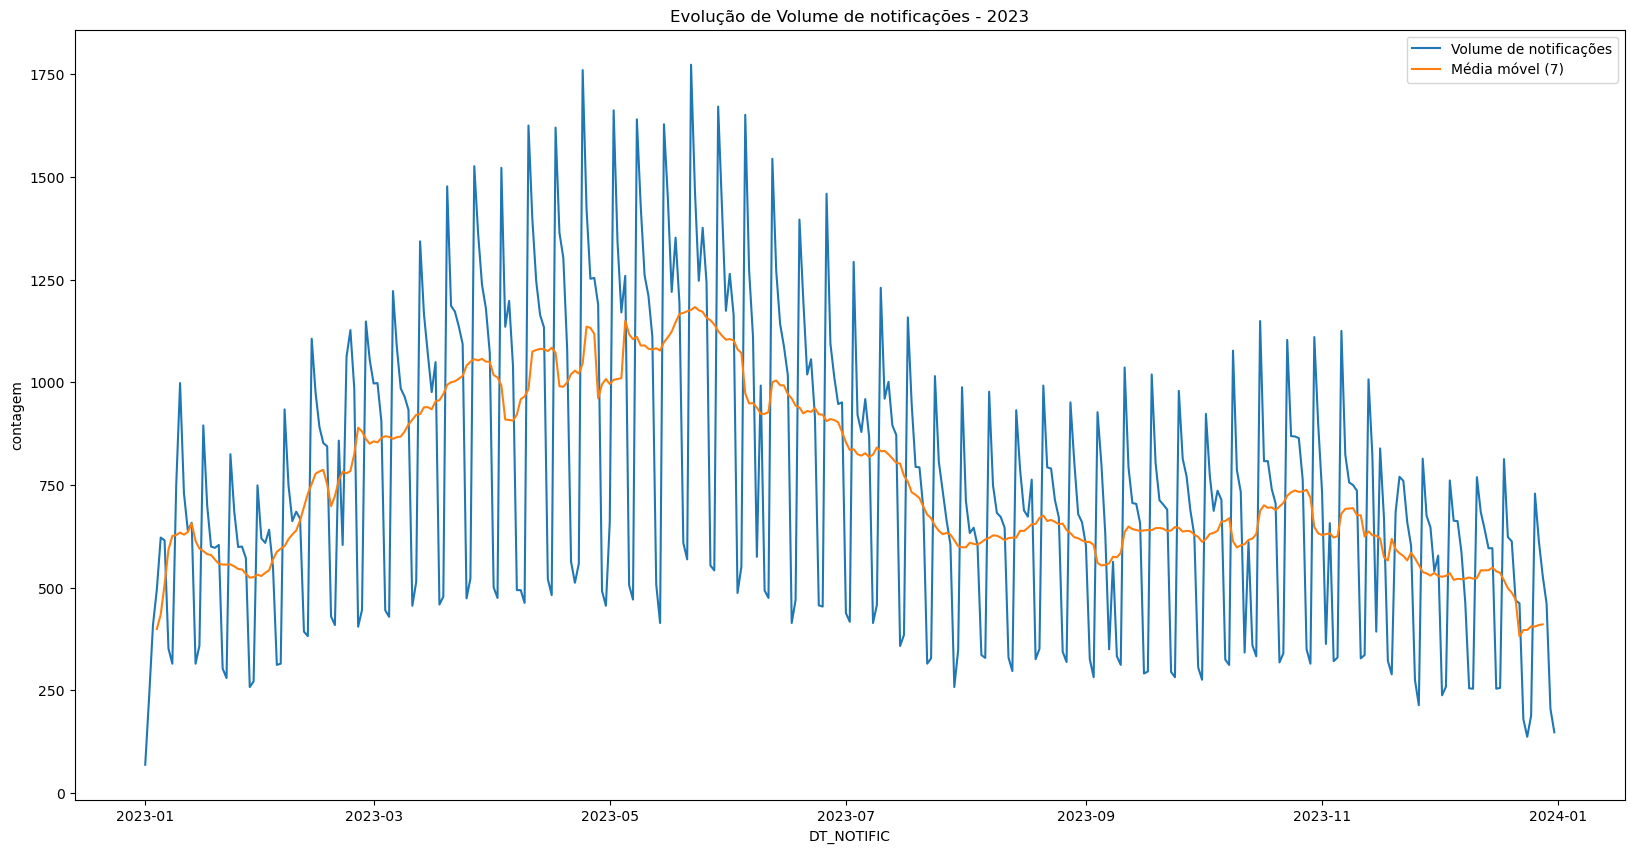

min: 69
max: 1773


In [32]:
# agrupando e usando size para contar o número de registros de data, ao invés de outra coluna
df_grup_notif = srag.groupby('DT_NOTIFIC').size().reset_index(name='contagem') # além disso count() so conta valores não nulos

df_grup_notif['MA7'] = df_grup_notif['contagem'].rolling(window=7, center=True).mean() # acrescentado após decomposição

# Plotando
sns.lineplot(data=df_grup_notif, x='DT_NOTIFIC', y='contagem', label='Volume de notificações')
sns.lineplot(data=df_grup_notif, x='DT_NOTIFIC', y='MA7', label='Média móvel (7)') # acrescentado após decomposição
plt.title('Evolução de Volume de notificações - 2023')
plt.show()

print('min: %d' % df_grup_notif['contagem'].min())
print('max: %d' % df_grup_notif['contagem'].max())

Podemos observar que os dados seguem um padrão (aparentemente semanal). Existe tammbém uma possível sazonalidade (apesar de só termos um ano de observações). Vamos decompor a série para podermos afirmar com mais clareza.

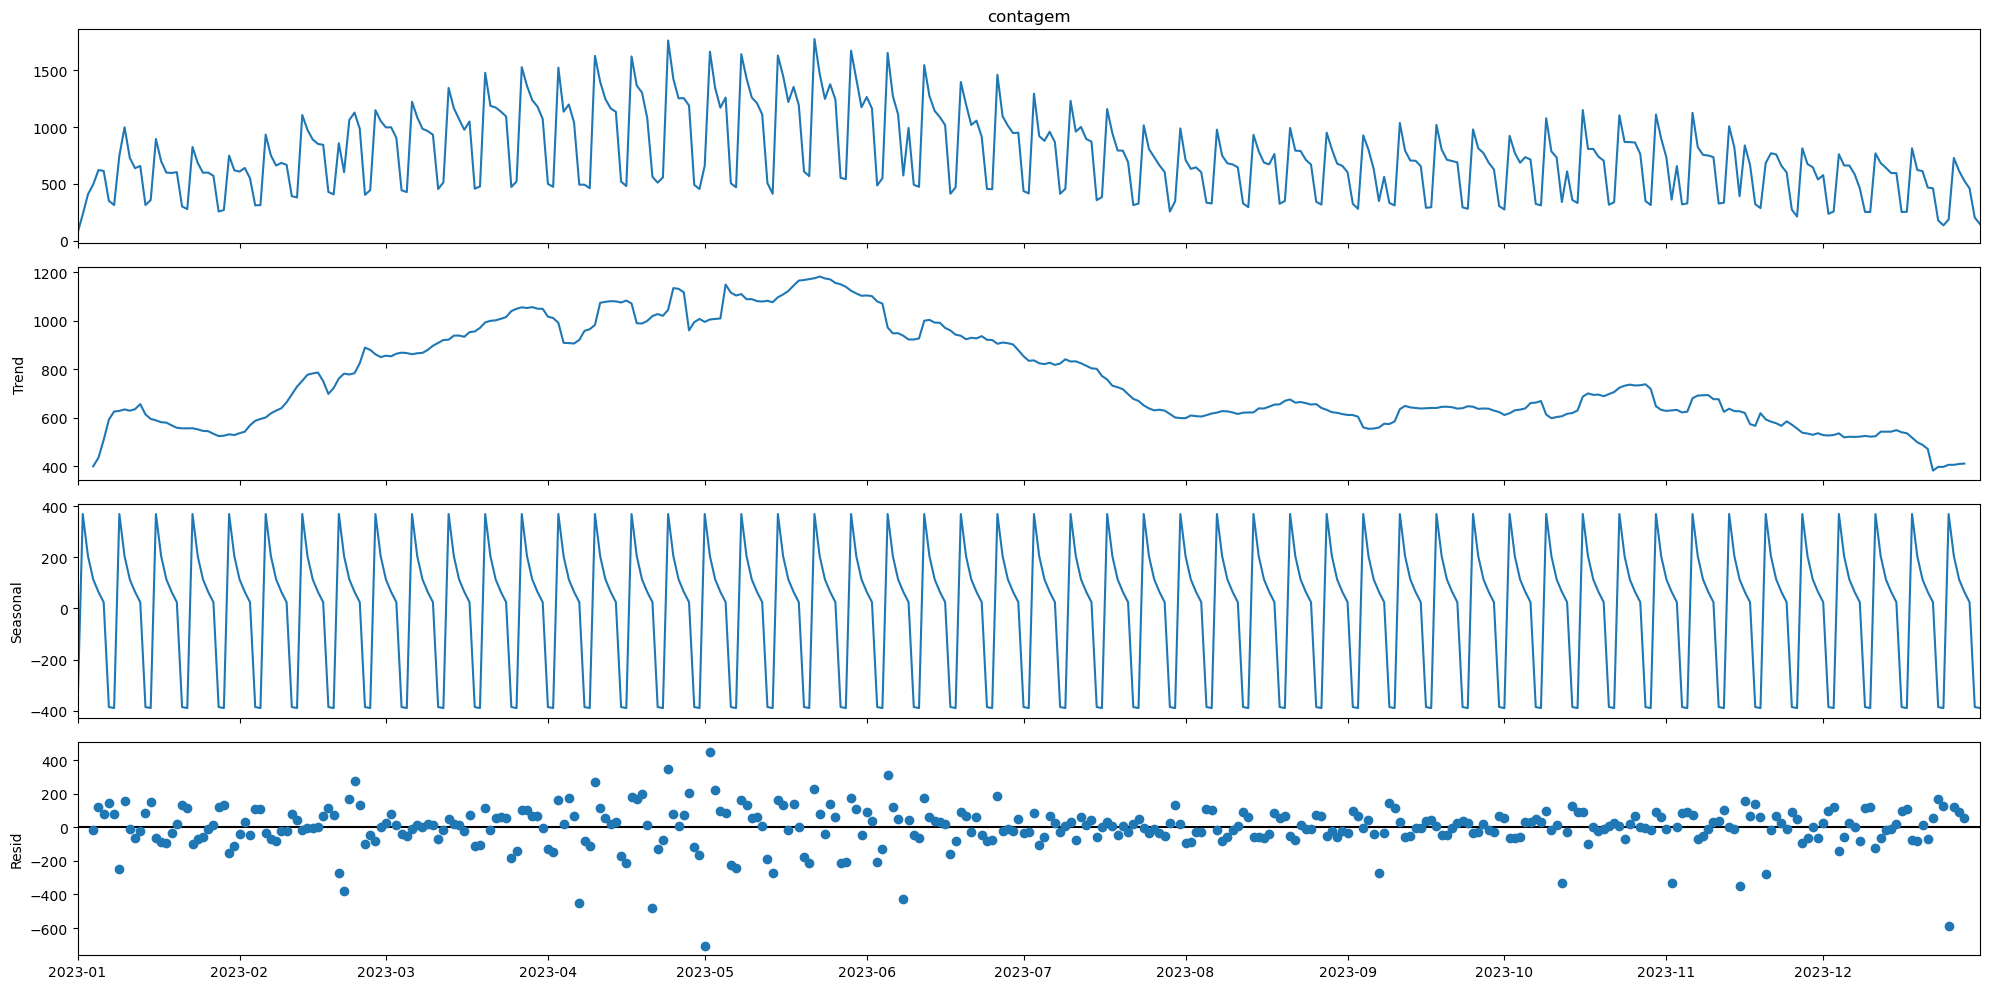

In [33]:
# plotando a decomposição sazonal
dfDia = df_grup_notif.set_index('DT_NOTIFIC')
decomp = seasonal_decompose(x = dfDia['contagem'], model = 'aditive') # assumindo que a que a tendência é aditiva
decomp.plot();

Conforme suspeitado, existe uma sazonalidade semanal, em que ocorre um pico de volume no início da semana e um declínio no final da semana.

A tendência indica que o volume atinge um pico por volta da metade do mês de maio (final do outono / início do inverno) e vai diminuindo até o fim do ano.

Visualmente o gráfico parece indicar um processo MA7, porém não vamos a fundo na análise de correlação e correlação parcial por fugir do objetivo (já que não estamos querendo modelar uma série temporal).

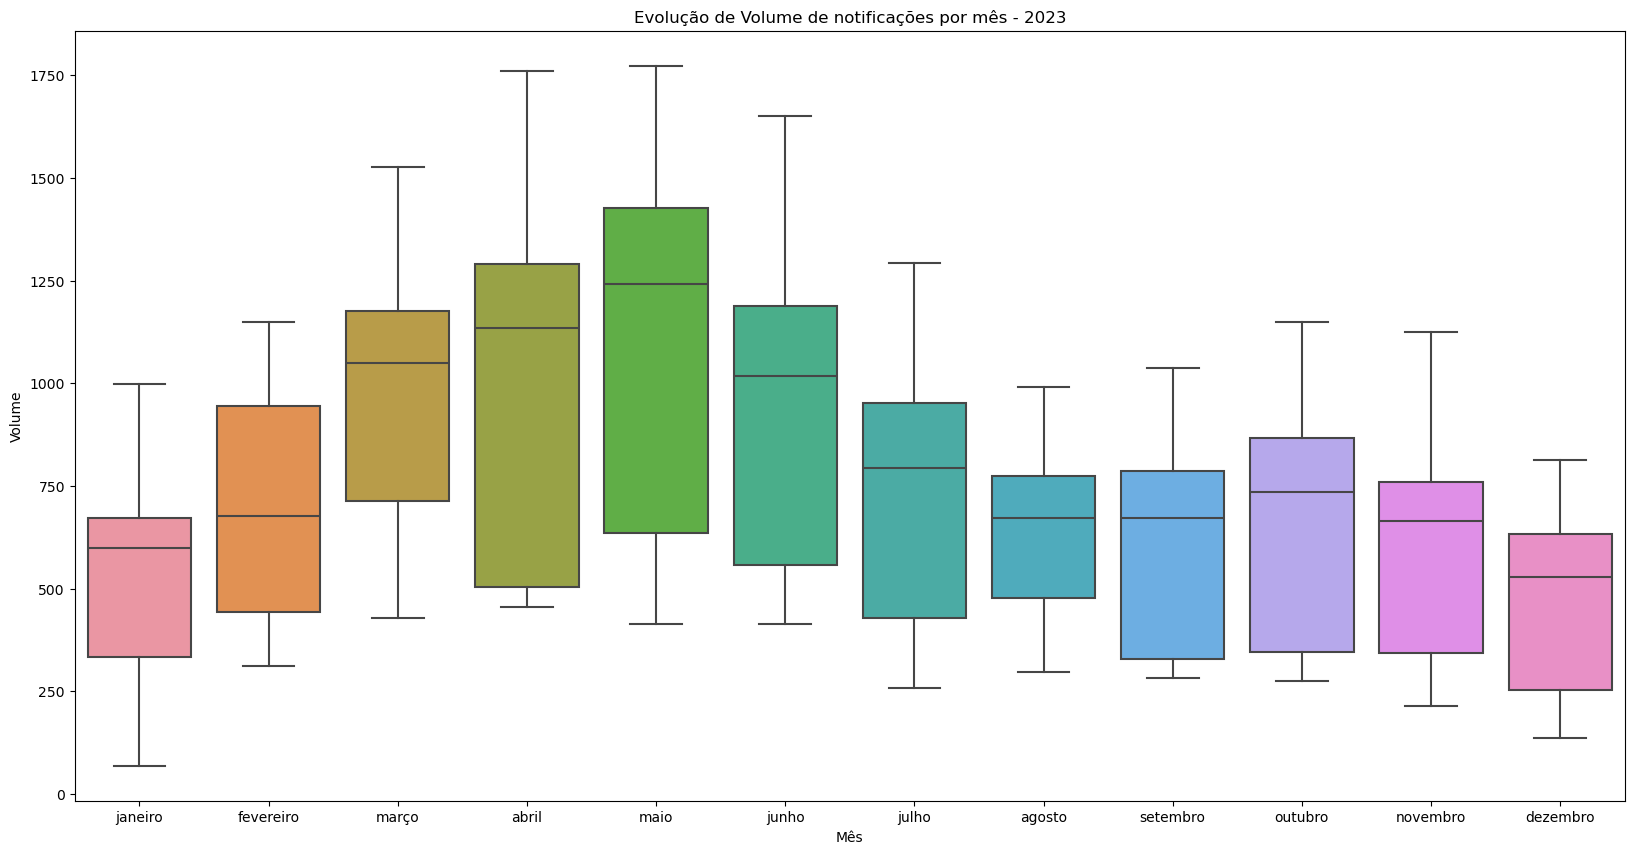

In [34]:
# criando colunas de mês
dfDia['n_mes'] = dfDia.index.month
dfDia['mes'] = dfDia['n_mes'].replace({1: 'janeiro', 2: 'fevereiro', 3: 'março', 4: 'abril', 5: 'maio', 6: 'junho',
                                            7: 'julho', 8: 'agosto', 9: 'setembro', 10: 'outubro', 11: 'novembro', 12: 'dezembro'})

# plotando
sns.boxplot(data=dfDia, x='mes', y='contagem')
plt.title('Evolução de Volume de notificações por mês - 2023')
plt.xlabel('Mês')
plt.ylabel('Volume')
plt.show()

* Mediana: começa baixa em janeiro e aumenta constantemente até atingir o pico por em maio, antes de diminuir gradualmente no final do ano.
* Mínimo: parece seguir a mesma tendência. O fato de os valores mínimos estarem aumentando indica que nos meses de maior demanda os dias de menor demanda também estão aumentando.
* Máximo: mostra muita variabilidade, com picos que indicam meses específicos (abr, mai, jun) em que as notificações aumentaram drasticamente. Esses podem ser períodos críticos de sobrecarga no sistema de saúde.
* Outliers: Não há.

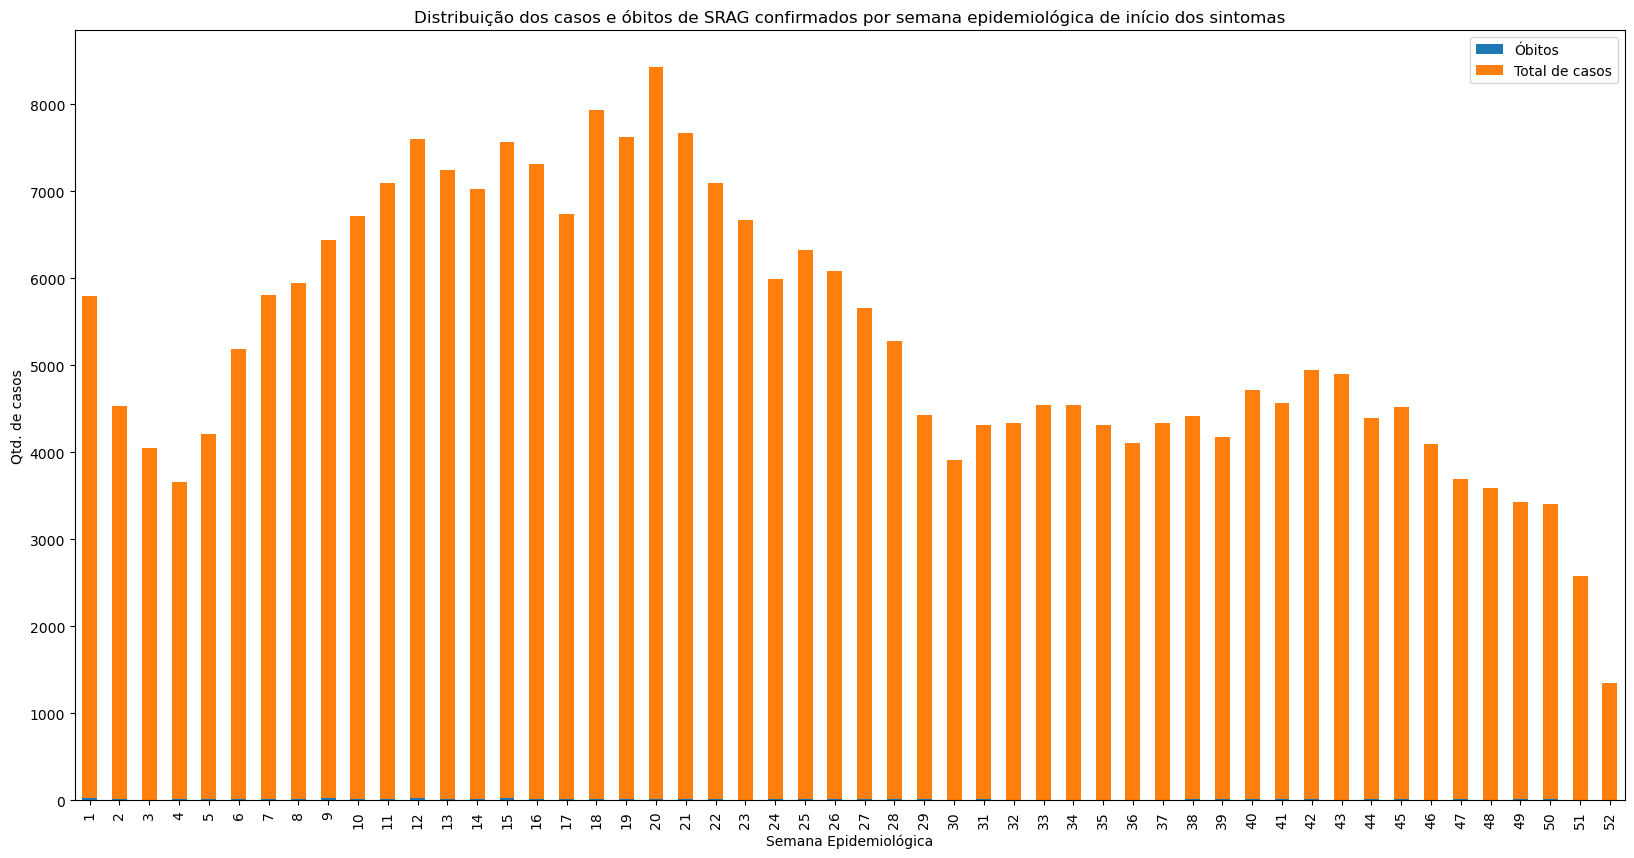

In [35]:
# agrupando e usando size para contar o número de registros
df_grup_sem = srag.groupby(['SEM_PRI','EVOLUCAO']).size().unstack(fill_value=0)
df_grup_sem['Total'] = df_grup_sem.sum(axis=1)
df_plot = df_grup_sem[['Total', 'Óbito']] # filtrando as colunas a serem utilizadas
df_plot['Total sem óbitos'] = df_plot['Total'] - df_plot['Óbito'] # subtraindo para não plotar duplicado

# plotando
df_plot[['Óbito', 'Total sem óbitos']].plot(kind='bar', stacked=True)
plt.title('Distribuição dos casos e óbitos de SRAG confirmados por semana epidemiológica de início dos sintomas')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Qtd. de casos')
plt.legend(['Óbitos', 'Total de casos'])
plt.show()

Olhando para todo o Brasil a letalidade parece bem baixa (quase não é possível visualizar no gráfico). Vamos calculá-la.

In [84]:
df_plot['% letalidade'] = (df_plot['Óbito'] / df_plot['Total']) * 100
letalidade = df_plot['% letalidade'].mean().round(2)
print(f'Letalidade geral: {letalidade}%')

Letalidade geral: 0.24%


### 3.2 - Análise geográfica

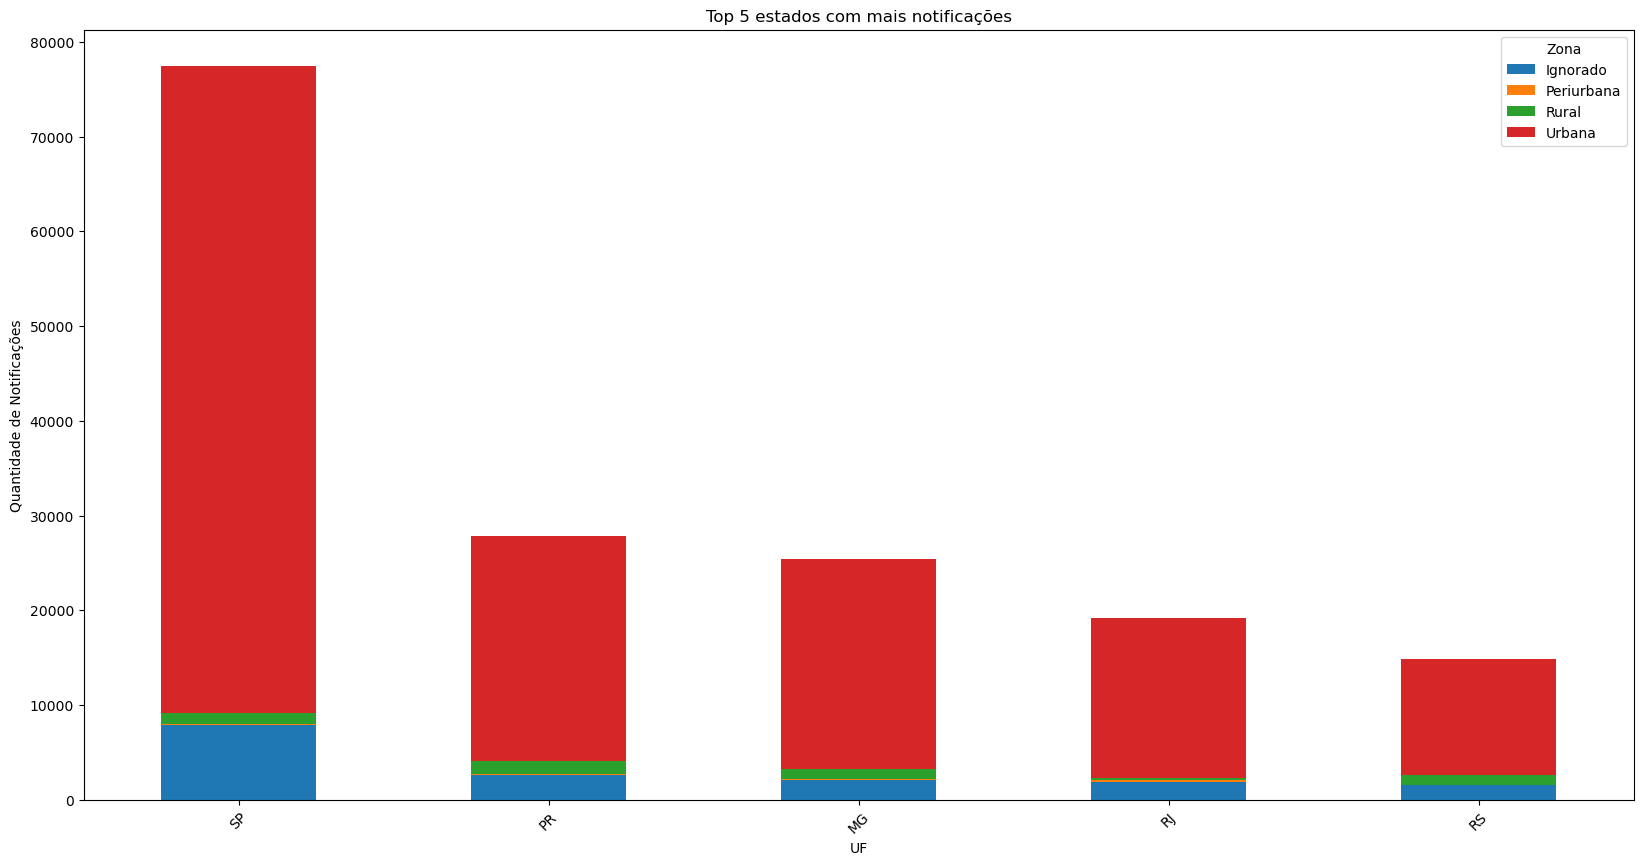

In [37]:
# viazualizando os top 5 estados por notificações de srag
top_5_uf = srag.groupby(['SG_UF', 'CS_ZONA']).size().unstack(fill_value=0).sort_values(by='Urbana', ascending=False).head()
top_5_uf.plot(kind='bar', stacked=True)
plt.title('Top 5 estados com mais notificações')
plt.xlabel('UF')
plt.ylabel('Quantidade de Notificações')
plt.xticks(rotation=45)
plt.legend(title='Zona')
plt.show()

Os estados com mais notificação são SP, PR, MG RJ e RS; todos com a maioria esmagadora dos casos na zona urbana. Porém é assim também que a população se distribui (estados de maior população e concentrados na zona urbana). Será que se olharmos as notificações proporcionais a população da UF o comportamento é o mesmo?

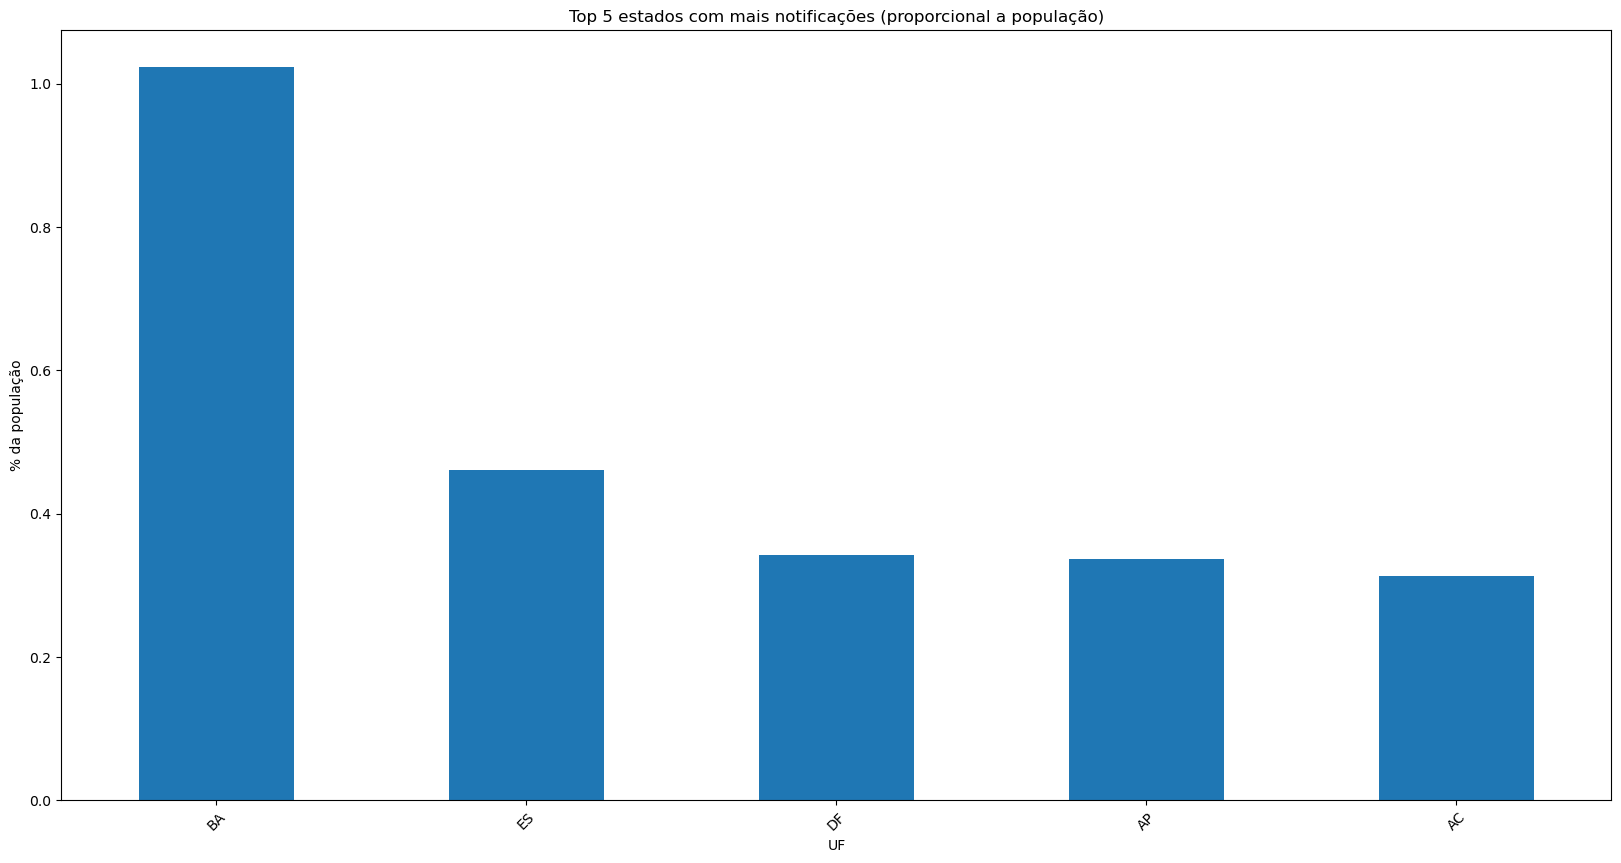

In [38]:
# definindo um dataframe com as populações dos estados segundo o senso 2022
pop = pd.DataFrame({"SG_UF":["SP","MG","RJ","BA","PR","RS","PE","CE","PA","SC","GO","MA","PB","AM","ES","MT","RN","PI","AL","DF","MS","SE","RO","TO","AC","AP","RR"],
                    "População":[44411238,20538718,16054524,1141626,11444380,10882965,9058931,8794957,8121025,7610361,7056495,6775805,3974687,3941613,833712,3658649,3302729,3271199,3127683,2817381,2757013,2209558,1581196,1511460,830018,733759,636707]
})

# agrupando e calculando o % de notidicações em relação a população
top5_uf_prop = pd.DataFrame(srag.groupby(['SG_UF']).size())
top5_uf_prop = top5_uf_prop.merge(pop, on='SG_UF')
top5_uf_prop['proporcao'] = (top5_uf_prop[0] / top5_uf_prop['População']) * 100
top5_uf_prop = top5_uf_prop.sort_values(by='proporcao', ascending=False).set_index('SG_UF').head()

# vizualizando os top 5 estados por notificações proporcionais de srag
top5_uf_prop['proporcao'].plot(kind='bar')
plt.title('Top 5 estados com mais notificações (proporcional a população)')
plt.xlabel('UF')
plt.ylabel('% da população')
plt.xticks(rotation=45)
plt.show()

Proporcionalmente o cenário é completamente diferente. Vemos que BA, ES, DF, AP e AC são os estados que mais possuem casos notificados proporcionalmente.

Vamos verificar a letalidade das UFs.

In [39]:
lista_UF = ["SP","MG","RJ","BA","PR","RS","PE","CE","PA","SC","GO","MA","PB","AM","ES","MT","RN","PI","AL","DF","MS","SE","RO","TO","AC","AP","RR"]

print("Letalidade da SRAG por UF:")
for uf in lista_UF:
    # agrupando e usando size para contar o número de registros
    df = srag[srag['SG_UF'] == uf]
    df_grup_sem = df.groupby(['SEM_PRI','EVOLUCAO']).size().unstack(fill_value=0)

    # se a UF não tem nenhum óbito, cria a coluna com 0 (criada para contornar erro)
    if 'Óbito' not in df_grup_sem.columns:
        df_grup_sem['Óbito'] = 0
    
    df_grup_sem['Total'] = df_grup_sem.sum(axis=1)
    df_plot = df_grup_sem[['Total', 'Óbito']] # filtrando as colunas a serem utilizadas
    df_plot['% letalidade'] = (df_plot['Óbito'] / df_plot['Total']) * 100
    print(f"{uf}: {df_plot['% letalidade'].mean():.2f}%")


Letalidade da SRAG por UF:
SP: 0.29%
MG: 0.30%
RJ: 0.51%
BA: 0.22%
PR: 0.20%
RS: 0.33%
PE: 0.36%
CE: 0.10%
PA: 0.26%
SC: 0.26%
GO: 0.26%
MA: 0.40%
PB: 0.32%
AM: 0.24%
ES: 0.18%
MT: 0.20%
RN: 0.62%
PI: 0.69%
AL: 0.22%
DF: 0.05%
MS: 0.27%
SE: 0.15%
RO: 0.83%
TO: 0.48%
AC: 0.64%
AP: 0.00%
RR: 0.66%


Podemos ver que, apesar de terem mais casos proporcionais a população, as UFs acima não são as mais preocupantes.

As 5 maiores letalidades são:
1. RO: 0.83%
2. PI: 0.69%
3. RR: 0.66%
4. AC: 0.63%
5. RN: 0.62%

Todos estados do eixo norte/nordeste do país.

### 3.3 - Análise de letalidade, sintomas e fatores de risco

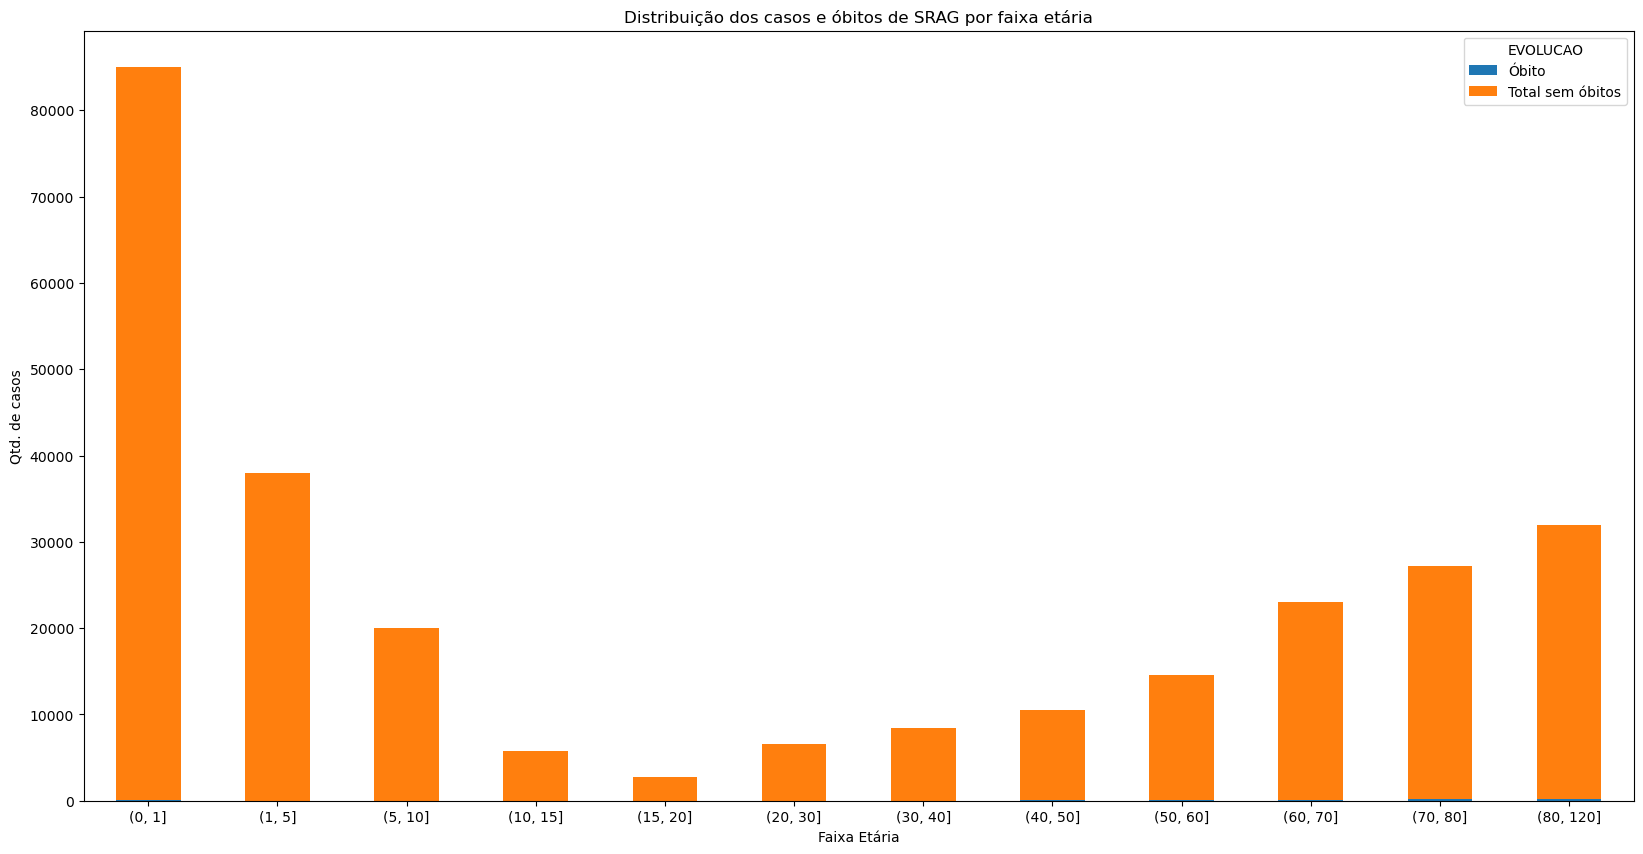

Faixa Etária
(0, 1]       0.04
(1, 5]       0.03
(5, 10]      0.02
(10, 15]     0.03
(15, 20]     0.26
(20, 30]     0.14
(30, 40]     0.28
(40, 50]     0.41
(50, 60]     0.53
(60, 70]     0.51
(70, 80]     0.65
(80, 120]    0.79
Name: % letalidade, dtype: float64


In [40]:
# distribuição por faixa etária

intervalos = [0, 1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 120]
faixa = ['< 1', '1-4', '5-9', '10-14', '15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
srag['Faixa Etária'] = pd.cut(srag['IDADE'], bins=intervalos)

# formatando para o histograma
df_hist = pd.crosstab(srag['Faixa Etária'], srag['EVOLUCAO'])
df_hist['Total'] = df_hist.sum(axis=1)
df_plot = df_hist[['Total', 'Óbito']] # filtrando as colunas a serem utilizadas
df_plot['Total sem óbitos'] = df_plot['Total'] - df_plot['Óbito'] # subtraindo para não plotar duplicado

# plotando
df_plot[['Óbito', 'Total sem óbitos']].plot(kind='bar', stacked=True)
plt.title('Distribuição dos casos e óbitos de SRAG por faixa etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Qtd. de casos')
plt.legend(title='EVOLUCAO')
plt.xticks(rotation=0)
plt.show()

# letalidade
df_plot['% letalidade'] = (df_plot['Óbito'] / df_plot['Total']) * 100
print(round(df_plot['% letalidade'], 2))

Podemos observar que a letalidade é proporcional a faixa etária, a partir dos 40 anos ela começa a crescer de 0,28% (próximo à média nacional) até chegar em 0,79% na faixa 80+

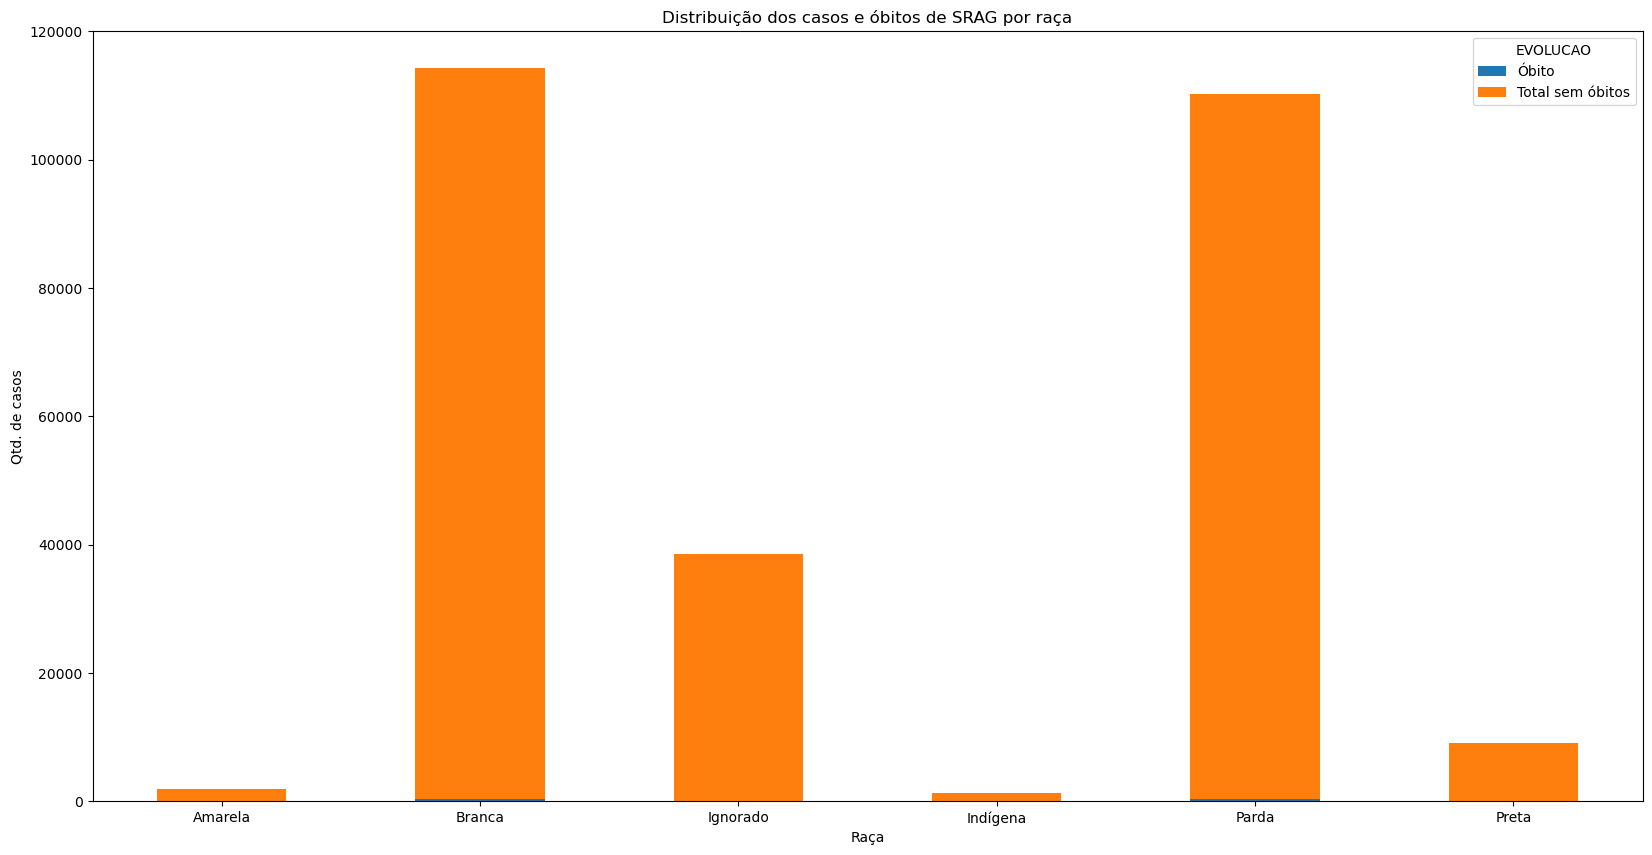

CS_RACA
Amarela     0.57
Branca      0.31
Ignorado    0.17
Indígena    0.23
Parda       0.26
Preta       0.42
Name: % letalidade, dtype: float64


In [41]:
# distribuição por raça

df_raca = srag.groupby(['CS_RACA', 'EVOLUCAO']).size().unstack(fill_value=0)
df_raca['Total'] = df_raca.sum(axis=1)
df_plot = df_raca[['Total', 'Óbito']] # filtrando as colunas a serem utilizadas
df_plot['Total sem óbitos'] = df_plot['Total'] - df_plot['Óbito'] # subtraindo para não plotar duplicado

# plotando
df_plot[['Óbito', 'Total sem óbitos']].plot(kind='bar', stacked=True)
plt.title('Distribuição dos casos e óbitos de SRAG por raça')
plt.xlabel('Raça')
plt.ylabel('Qtd. de casos')
plt.legend(title='EVOLUCAO')
plt.xticks(rotation=0)
plt.show()

# letalidade
df_plot['% letalidade'] = (df_plot['Óbito'] / df_plot['Total']) * 100
print(round(df_plot['% letalidade'], 2))

A letalidade também é maior entre pessoas pretas e indígenas, provavelmente por se concentrarem principalmente nas regiões norte/nordeste. (A maior proporção de pretos está na região nordeste, e a maior proporção de indígenas está no norte. [Fonte](https://sidra.ibge.gov.br/tabela/9605#resultado))

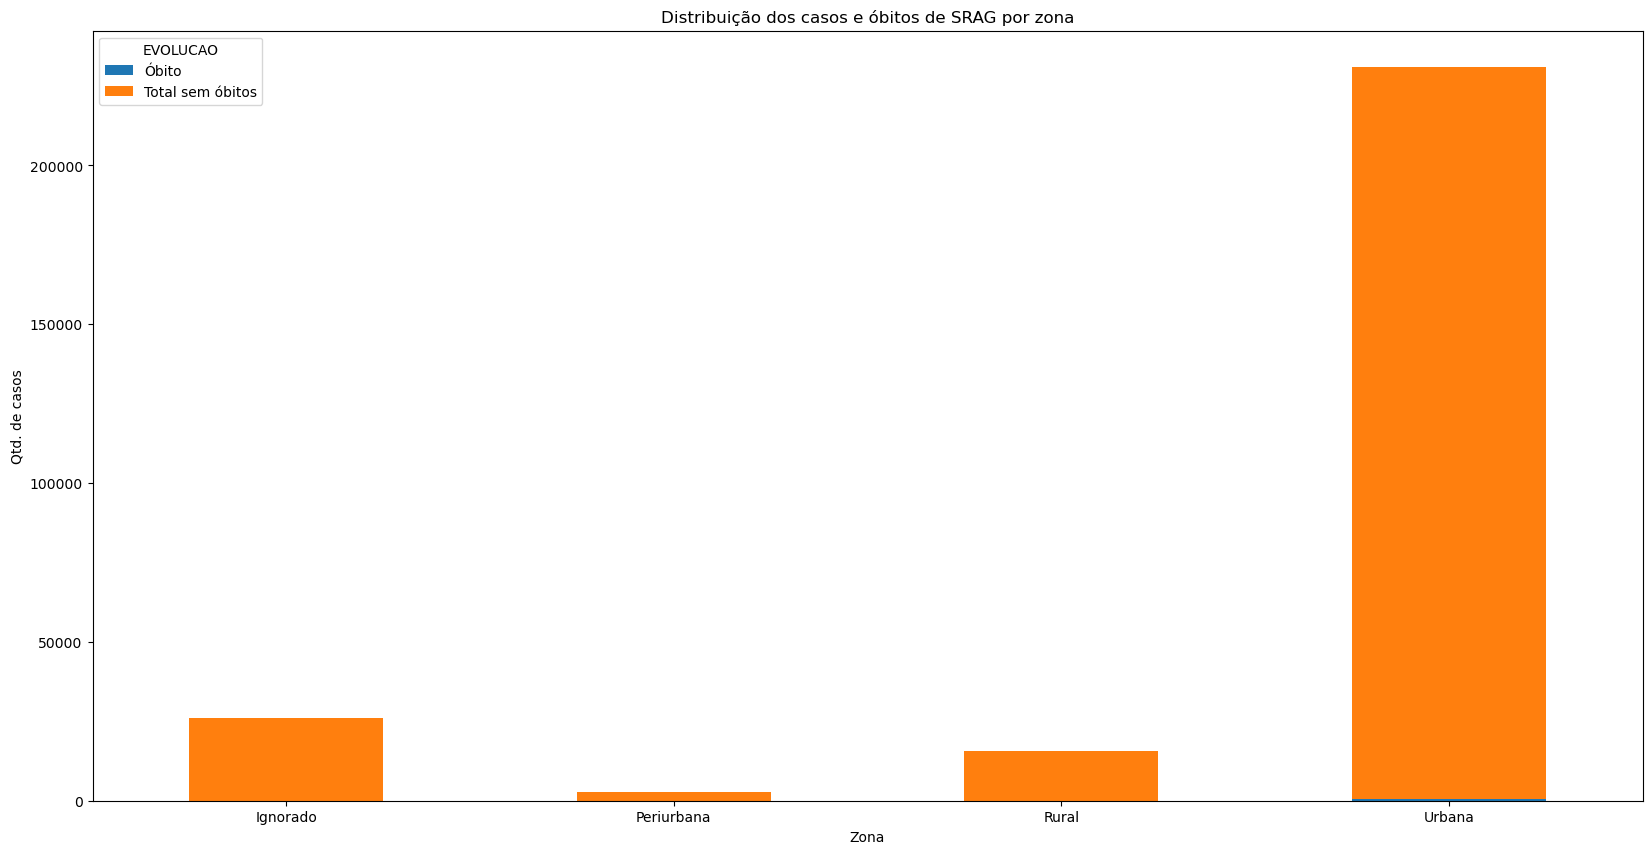

CS_ZONA
Ignorado      0.24
Periurbana    0.10
Rural         0.34
Urbana        0.28
Name: % letalidade, dtype: float64


In [42]:
# distribuição por zona

df_zona = srag.groupby(['CS_ZONA', 'EVOLUCAO']).size().unstack(fill_value=0)
df_zona['Total'] = df_zona.sum(axis=1)
df_plot = df_zona[['Total', 'Óbito']] # filtrando as colunas a serem utilizadas
df_plot['Total sem óbitos'] = df_plot['Total'] - df_plot['Óbito'] # subtraindo para não plotar duplicado

# plotando
df_plot[['Óbito', 'Total sem óbitos']].plot(kind='bar', stacked=True)
plt.title('Distribuição dos casos e óbitos de SRAG por zona')
plt.xlabel('Zona')
plt.ylabel('Qtd. de casos')
plt.legend(title='EVOLUCAO')
plt.xticks(rotation=0)
plt.show()

# letalidade
df_plot['% letalidade'] = (df_plot['Óbito'] / df_plot['Total']) * 100
print(round(df_plot['% letalidade'], 2))

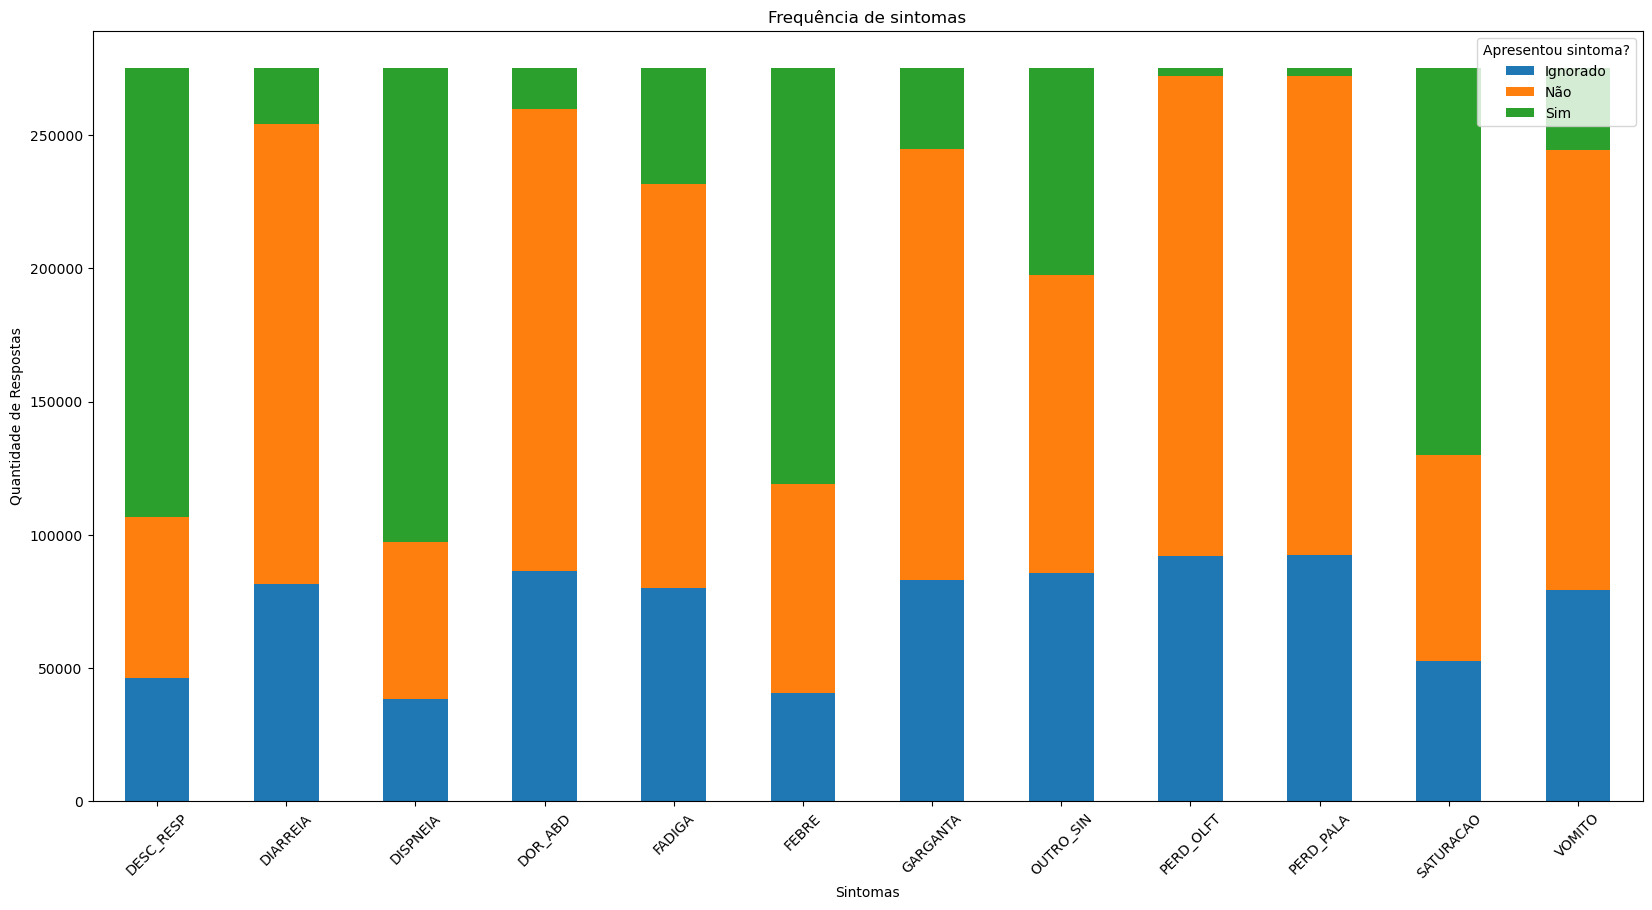

In [43]:
# analise de sintomas

df_sintomas = srag[lista_sintomas]

# juntando as colunas para contagem
df_melt = df_sintomas.melt(var_name='sintoma', value_name='resposta')

# contando respostas
cont_resp = df_melt.groupby(['sintoma', 'resposta']).size().unstack(fill_value=0)

# plotando
cont_resp.plot(kind='bar', stacked=True)
plt.title('Frequência de sintomas')
plt.xlabel('Sintomas')
plt.ylabel('Quantidade de Respostas')
plt.xticks(rotation=45)
plt.legend(title='Apresentou sintoma?')
plt.show()

Podemos ver que os sintomas mais comuns da SRAG são respectivamente:
1. Dispneia (falta de ar)
2. Desconforto respiratório
3. Febre
4. Saturação (O2 < 95% no sangue)

In [44]:
# fatores de risco

num_sim = len(srag[srag['FATOR_RISC'] == 'Sim'])
total = len(srag)
sim_percent = (num_sim / total) * 100
print(f"{sim_percent:.2f}% dos casos notificados possuem algum fator de risco.")

44.78% dos casos notificados possuem algum fator de risco.


In [45]:
# letalidade para cada categoria de fator de risco

# agrupando e contando
df_agrupado = srag.groupby(['FATOR_RISC', 'EVOLUCAO']).size().unstack(fill_value=0)
df_agrupado['Total'] = df_agrupado.sum(axis=1)
df_agrupado['Óbito'] = df_agrupado.get('Óbito', 0)  # tratamento caso não tenha óbitos

# calculando letalidade
df_agrupado['% Letalidade'] = (df_agrupado['Óbito'] / df_agrupado['Total']) * 100

print(round(df_agrupado['% Letalidade'], 2))

FATOR_RISC
Não    0.11
Sim    0.48
Name: % Letalidade, dtype: float64


A letalidade para quem tem algum fator de risco é mais de 4x maior do que para quem não tem.

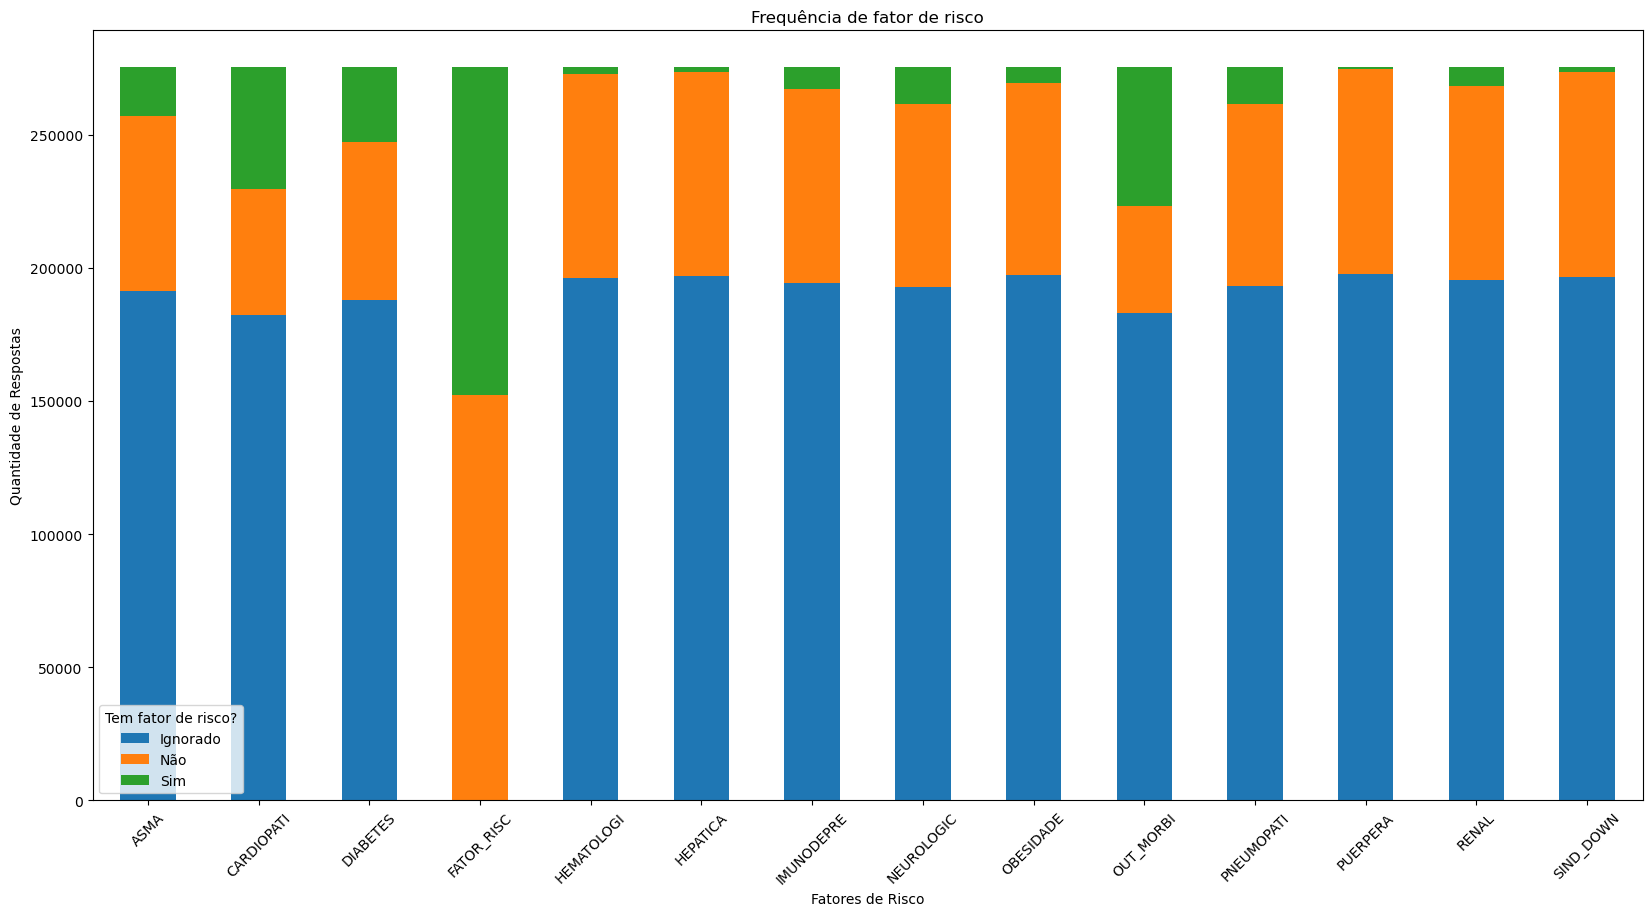

In [46]:
# fatores de risco

df_risco = srag[fatores_risco]

# juntando as colunas para contagem
df_melt = df_risco.melt(var_name='sintoma', value_name='resposta')

# contando respostas
cont_resp = df_melt.groupby(['sintoma', 'resposta']).size().unstack(fill_value=0)

# plotando
cont_resp.plot(kind='bar', stacked=True)
plt.title('Frequência de fator de risco')
plt.xlabel('Fatores de Risco')
plt.ylabel('Quantidade de Respostas')
plt.xticks(rotation=45)
plt.legend(title='Tem fator de risco?')
plt.show()

Podemos ver que os fatores de risco mais comuns para casos de SRAG são respectivamente:
1. Doença Cardiovascular Crônica
2. Diabetes
3. Asma

In [47]:
# letalidade por fator de risco

letalidades = {}

# loop ppara calular a letalidade de cada fator
for fator in fatores_risco:
    df_fatores = srag[srag[fator] == 'Sim']
    total = len(df_fatores)
    obitos = (df_fatores['EVOLUCAO'] == 'Óbito').sum()
    
    # calculando a letalidade
    if total > 0:  # tratar divisao por 0
        letalidade = (obitos / total) * 100
    else:
        letalidade = 0
    
    letalidades[fator] = letalidade
letalidades

{'FATOR_RISC': 0.4760012650118797,
 'ASMA': 0.15233949945593037,
 'CARDIOPATI': 0.6087546806227692,
 'DIABETES': 0.624955613947873,
 'HEMATOLOGI': 0.47899778924097275,
 'HEPATICA': 0.593952483801296,
 'IMUNODEPRE': 0.6176577449436842,
 'NEUROLOGIC': 0.5588593537293115,
 'OBESIDADE': 0.3781029097484794,
 'OUT_MORBI': 0.5730438628540662,
 'PNEUMOPATI': 0.6379928315412187,
 'PUERPERA': 0.0,
 'RENAL': 0.8162116521249648,
 'SIND_DOWN': 0.3540718259989884}

Os fatores de risco mais letais são:
1. Doença Renal Crônica (0,81%)
2. Outra Pneumatopatia Crônica (0,62%)
3. Diabetes (0,62%)

In [48]:
# analise de letalidade entre pacientes internados

# agrupando e contando
df_inter = srag.groupby(['HOSPITAL', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'HOSPITAL'
df_inter['Total'] = df_inter.sum(axis=1)

# calculando a letalidade
df_inter['Óbito'] = df_inter.get('Óbito', 0)  # tratamento caso não tenha óbitos
df_inter['% Letalidade'] = (df_inter['Óbito'] / df_inter['Total']) * 100

df_inter.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
HOSPITAL,,,,,,
Ignorado,152,7707,17,3,7879,0.22
Não,69,4633,46,7,4755,0.97
Sim,6145,255675,696,219,262735,0.26


In [49]:
# analise de letalidade entre pacientes internados em UTI

# agrupando e contando
df_uti = srag.groupby(['UTI', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'UTI'
df_uti['Total'] = df_uti.sum(axis=1)

# calculando a letalidade
df_uti['Óbito'] = df_uti.get('Óbito', 0)  # tratamento caso não tenha óbitos
df_uti['% Letalidade'] = (df_uti['Óbito'] / df_uti['Total']) * 100

df_uti.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
UTI,,,,,,
Ignorado,762,35095,109,39,36005,0.30
Não,4117,161473,280,68,165938,0.17
Sim,1487,71447,370,122,73426,0.50


In [50]:
# analise de letalidade entre pacientes intubados

# agrupando e contando
df_vent = srag.groupby(['SUPORT_VEN', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'SUPORT_VEN'
df_vent['Total'] = df_vent.sum(axis=1)

# calculando a letalidade
df_vent['Óbito'] = df_vent.get('Óbito', 0)  # tratamento caso não tenha óbitos
df_vent['% Letalidade'] = (df_vent['Óbito'] / df_vent['Total']) * 100

df_vent.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
SUPORT_VEN,,,,,,
Ignorado,913,39891,97,30,40931,0.24
Não,1993,75055,84,26,77158,0.11
Sim,3460,153069,578,173,157280,0.37


### 3.4 Tratamentos e vacina

In [51]:
srag['CLASSI_FIN'].value_counts()

CLASSI_FIN
Não especificado            161259
COVID                        49213
Outro vírus respiratório     48048
Influenza                    13309
Outro agente etiológico       3540
Name: count, dtype: int64

In [52]:
# analise de letalidade entre pacientes que receberam tratamento para COVID

# filtrando apenas para casos confirmados de covid
casos_covid = srag[srag['CLASSI_FIN'] == 'COVID']

# agrupando e contando
df_trat = casos_covid.groupby(['TRAT_COV', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'TRAT_COV'
df_trat['Total'] = df_trat.sum(axis=1)

# calculando a letalidade
df_trat['Óbito'] = df_trat.get('Óbito', 0)  # tratamento caso não tenha óbitos
df_trat['% Letalidade'] = (df_trat['Óbito'] / df_trat['Total']) * 100

df_trat.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
TRAT_COV,,,,,,
Ignorado,425,19502,96,17,20040,0.48
Não,604,26835,189,20,27648,0.68
Sim,38,1468,17,2,1525,1.11


In [53]:
# analise de letalidade entre pacientes que receberam vacina para gripe

# filtrando apenas para casos confirmados de influenza
casos_gripe = srag[srag['CLASSI_FIN'] == 'Influenza']

# agrupando e contando
df_trat = casos_gripe.groupby(['VACINA', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'VACINA'
df_trat['Total'] = df_trat.sum(axis=1)

# calculando a letalidade
df_trat['Óbito'] = df_trat.get('Óbito', 0) # tratamento caso não tenha óbitos
df_trat['% Letalidade'] = (df_trat['Óbito'] / df_trat['Total']) * 100

df_trat.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
VACINA,,,,,,
Ignorado,201,8918,18,8,9145,0.20
Não,85,3069,9,2,3165,0.28
Sim,28,966,4,1,999,0.40


In [54]:
# analise de letalidade entre pacientes que receberam vacina para covid

# agrupando e contando
df_trat = casos_covid.groupby(['VACINA_COV', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'VACINA'
df_trat['Total'] = df_trat.sum(axis=1)

# calculando a letalidade
df_trat['Óbito'] = df_trat.get('Óbito', 0) # tratamento caso não tenha óbitos
df_trat['% Letalidade'] = (df_trat['Óbito'] / df_trat['Total']) * 100

df_trat.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
VACINA_COV,,,,,,
Ignorado,8,520,5,0,533,0.94
Não,240,9573,33,4,9850,0.34
Sim,819,37712,264,35,38830,0.68


Vimos acima alguns resultados contraditórios, onde a letalidade é maior tanto para vacinados quanto para pacientes que receberam tratamento. Podemos pensar em algumas causas para isso como o fato de termos um número de vacinados maior do que de não vacinados ou por exemplo a idade dos pacientes, uma vez que sabemos que a letalidade é baixísima em crianças, esses pacientes enviesam nossa análise. Se filtrarmos os casos confirmados por idades mais avançadas, vemos cada vez mais a letalidade aumentando para não vacinados.

In [55]:
# analise de letalidade entre pacientes que receberam vacina para covid

casos_covid1 = casos_covid[casos_covid['IDADE'] > 15]

# agrupando e contando
df_trat = casos_covid1.groupby(['VACINA_COV', 'EVOLUCAO']).size().unstack(fill_value=0)

# calculando o total para cada resposta em 'VACINA'
df_trat['Total'] = df_trat.sum(axis=1)

# calculando a letalidade
df_trat['Óbito'] = df_trat.get('Óbito', 0) # tratamento caso não tenha óbitos
df_trat['% Letalidade'] = (df_trat['Óbito'] / df_trat['Total']) * 100

df_trat.round(2)

EVOLUCAO,Cura,Ignorado,Óbito,Óbito por outras causas,Total,% Letalidade
VACINA_COV,,,,,,
Ignorado,6,384,4,0,394,1.02
Não,62,3212,25,4,3303,0.76
Sim,773,36217,263,34,37287,0.71


Porém não apenas isso, não basta apenas contar as mortes e compará-las entre vacinados e não vacinados, uma análise mais justa levaria em conta quantas pessoas foram vacinadas na população e se receberam o ciclo completo. Além disso, o dataframe é apenas uma amostra da população, não sendo necessariamente uma amostra representativa.

"Quando se compara coeficientes de mortalidade (expressos pelo número de óbitos por 100000 pessoas) ao invés de números absolutos de mortes entre vacinados e não vacinados, a diferença entre eles é marcante. Entre as pessoas não vacinadas o coeficiente semanal de mortalidade por 100 000 pessoas (padronizado por idade, para a população de 12 anos de idade ou mais) foi de 1,71, enquanto entre as pessoas vacinadas e que receberam reforço(s) ele foi de, respectivamente, 0,22 e 0,1 por 100 000."
[unasus](https://www.unasus.gov.br/especial/covid19/markdown/548)

## 4 - Conclusões

### 4.1 - Insights

#### Temporais

* As notificações dos casos tem um padrão sazonal semanal, as segundas-feiras tem maior volume de notificação.
* Os casos aumentaram até atigir um pico em maio e desde então, vieram seguindo uma tendência de queda.
* A letalidade média no ano de 2022 foi de 0.28%, totalizando 759 óbitos no ano.

#### Geográficos

* As 5 UFs com maior volume de notificações estão no sul/sudeste, porém as maiores letalidades estão no eixo norte/nordeste, possivelmente devido a razões de dificuldade de acesso à serviços de saúde.
* A letalidade também é maior entre pessoas pretas e indígenas, provavelmente por se concentrarem principalmente nas regiões norte/nordeste.
* O maior volume de casos se concentra em zonas urbanas, porém a doença é mais letal em zonas rurais, pelos mesmos motivos.
* A letalidade é proporcional a faixa etária, a partir dos 40 anos ela começa a crescer de 0,28% (próximo à média nacional) até chegar em 0,79% na faixa 80+

#### Sintomas

Os sintomas mais comuns da SRAG são respectivamente:
1. Dispneia (falta de ar)
2. Desconforto respiratório
3. Febre
4. Saturação (O2 < 95% no sangue)

#### Fatores de Risco

* Em 44.78% dos casos notificados, o paciente possuiu algum fator de risco.
* A doença é 4x mais letal para quem possui algum fator de risco.

Os fatores de risco mais comuns para casos de SRAG são respectivamente:
1. Doença Cardiovascular Crônica
2. Diabetes
3. Asma

Os fatores de risco mais letais são:
1. Doença Renal Crônica (0,81%)
2. Outra Pneumatopatia Crônica (0,62%)
3. Diabetes (0,62%)

- Pacientes que acabam na UTI, morrem 3x mais do que pacientes que não precisaram serem internados sob cuidados intensivos. 
- Na mesma linha, pacientes internados que precisaram de intubação morrem 3x mais do que pacientes que não precisaram de suporte ventilatório.

### 4.2 - intervenções

* Intensificar campanhas de conscientização e prevenção em regiões com altas taxas de letalidade, em especial nas regiõe Norte e Nordeste, sobre a importância do acesso a serviços de saúde, além de abordar também sobre tratamentos de doenças crônicas (fatores de risco)
  * Monitoramento de cobertura vacinal e intensificação de campanhas nessas regiões.
* Campanhas de vacinação focadas em idosos, visto que a letalidade aumenta com a idade.
* Desenvolver um sistema integrado de gerenciamento de fatores de risco para identificar e monitorar pacientes em alto risco de complicações por SRAG